# Project: Applied Machine Learning

This notebook was created by Lennart Onghena, Roel Moeyersoons and Tim De Smet.


This project is a collaboration with ML6. They are launching a product that automates parts of big email inboxes.


During `sprint 1` we decided to create a classifier that would be able to assign a general product class to the message of the customers.

# 1. Exploratory Data Analysis (EDA)

First we need to explore the data in order to know what we are working with:
•	How much data do we have?
•	What types of data?
•	How is the data distributed?
•	What is the meaning of the data?

## 1.1. The Data

The data is gathered from the consumer complaint database of the consumer financial protection bureau. The Consumer Complaint Database is a collection of complaints about consumer financial products and services that we sent to companies for response.


The features of the data are explained here
[here](https://cfpb.github.io/api/ccdb/fields.html)

In [1]:
# All imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn import svm

%matplotlib inline

In order to collaborate easily we started out by creating a Google Colab notebook, and uploaded the .csv datafile to Google Cloud Storage. This would have added the extra benefit that we would have been able to use a specilized Google GPU for training our models. However, because of the size of the datafile our team decided it would be easier for everyone to store the data locally and use a plain Jupyter notebook.

First we need to read the data that we stored locally using the pandas library.

In [2]:
# Use pandas to read csv data into DataFrame
complaints = pd.read_csv('complaints-2020-01-22_08_24.csv')

Usinge the .info() function, that prints a concise summary of the DataFrame, we can determine the following about the data:
* There are a total of 485701 complaints
* There are a total of 18 features, one of which is numeric
* There are no missing values, so we don't have to eliminate these datapoints 

In [3]:
complaints.info()
# Example of a single datapoint
complaints.head(1)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485701 entries, 0 to 485700
Data columns (total 18 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 485701 non-null  object
 1   Product                       485701 non-null  object
 2   Sub-product                   485701 non-null  object
 3   Issue                         485701 non-null  object
 4   Sub-issue                     485701 non-null  object
 5   Consumer complaint narrative  485701 non-null  object
 6   Company public response       485701 non-null  object
 7   Company                       485701 non-null  object
 8   State                         485701 non-null  object
 9   ZIP code                      485701 non-null  object
 10  Tags                          485701 non-null  object
 11  Consumer consent provided?    485701 non-null  object
 12  Submitted via                 485701 non-null  object
 13 

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
0,07/23/19,"Credit reporting, credit repair services, or o...",Credit reporting,Credit monitoring or identity theft protection...,Problem canceling credit monitoring or identif...,I have complained many times that the credit r...,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,CA,926XX,None,Consent provided,Web,07/23/19,Closed with explanation,Yes,NaN,3315279


At this point we looked at what the most interesting features were for this dataset. As stated earlier we wanted to create a classifier that would be able to assign a class of product based solely upon the message of the customer.

The first thing we asked ourself was: What kinds of products are there, and how are the complaints distributed between them?

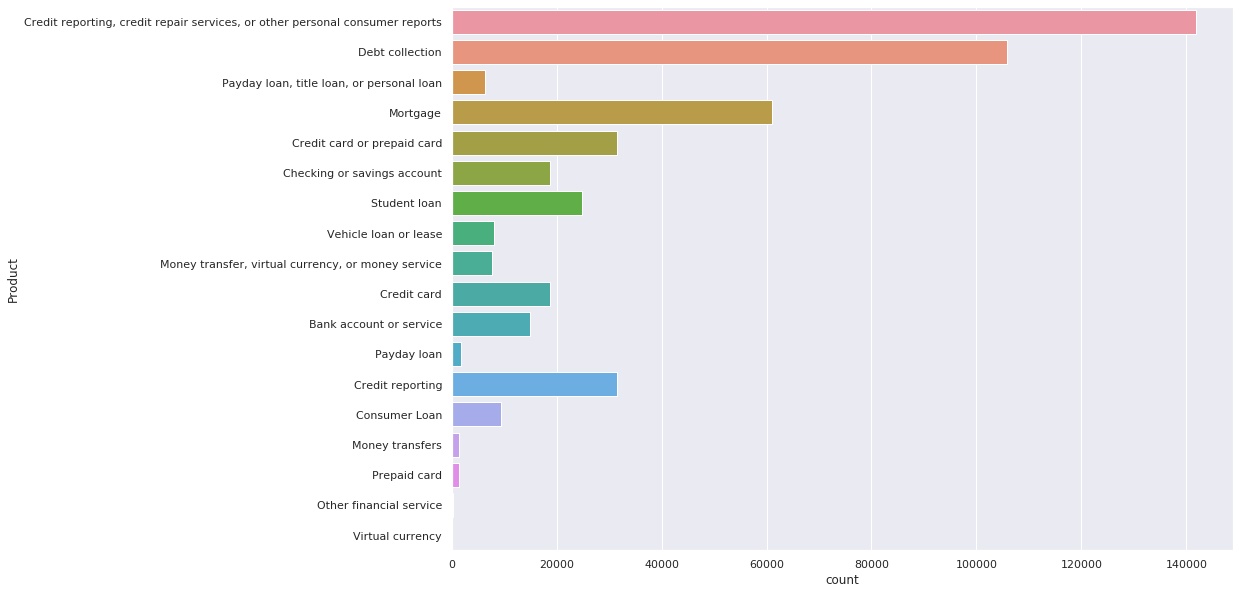

In [4]:
# Visual representation of the amount of complaints related to certain products
plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='Product', data=complaints)
plt.show()

By doing this we noticed that the dataset was an imbalanced one. We adress this further in section 1.2.

Let's now take the subproducts into consideration as well; Below are the amount of complaints received about the different products and subproducts:

In [5]:
temp = complaints['Product'].value_counts();

for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Product'] == temp.index[i]]['Sub-product'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Credit reporting, credit repair services, or other personal consumer reports: 141742
		Credit reporting: 138534
		Other personal consumer report: 2481
		Credit repair services: 726
		Conventional home mortgage: 1

Debt collection: 105765
		I do not know: 20639
		Other debt: 18699
		Credit card debt: 14522
		Other (i.e. phone, health club, etc.): 12389
		Medical debt: 11239
		Credit card: 7520
		Medical: 6990
		Payday loan debt: 2461
		Auto debt: 2319
		Payday loan: 2064
		Mortgage debt: 1500
		Federal student loan debt: 1126
		Private student loan debt: 1093
		Auto: 1064
		Mortgage: 907
		Non-federal student loan: 684
		Federal student loan: 549

Mortgage: 61094
		Conventional home mortgage: 17063
		Conventional fixed mortgage: 14562
		FHA mortgage: 11341
		Conventional adjustable mortgage (ARM): 4975
		VA mortgage: 3437
		Other mortgage: 3236
		Home equity loan or line of credit: 2103
		Other type of mortgage: 2011
		Home equity loan or line of credit (HELOC): 1690
		Reverse mortgage

From this we can see that "Debt Collection" is a huge category, with also many different sub-products. This could be an interesting category that might be used later on. For example to determine the right subproduct category. For now let's just visualize this category with a pie chart:

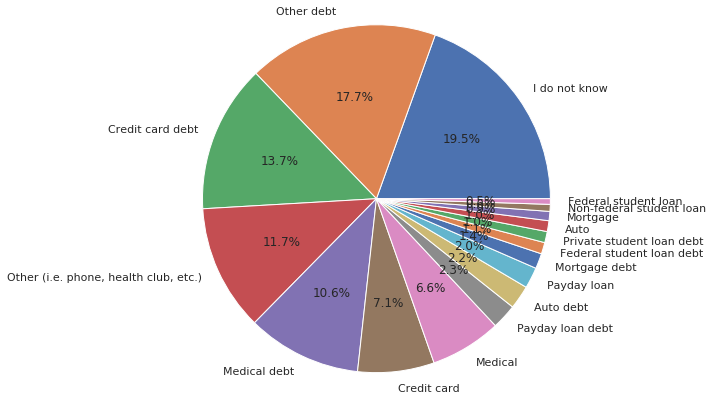

In [6]:
products = complaints["Product"].unique()

debt = complaints[complaints["Product"] == "Debt collection"]
subProdCount = debt["Sub-product"].value_counts()#[:10]

#plt.title("Debt Collection")
patches, texts, autotexts = plt.pie(subProdCount.values, labels = subProdCount.index, radius = 2, autopct="%.1f%%",)
for t in autotexts:
    t.set_fontsize(12)
plt.show()

We will also visualize every product and it's subproducts this way. We could have opted to use distribution plots (example: sns.distplot(...)) however due to the naming of the categories the visualisation in pie charts seemed more clear.

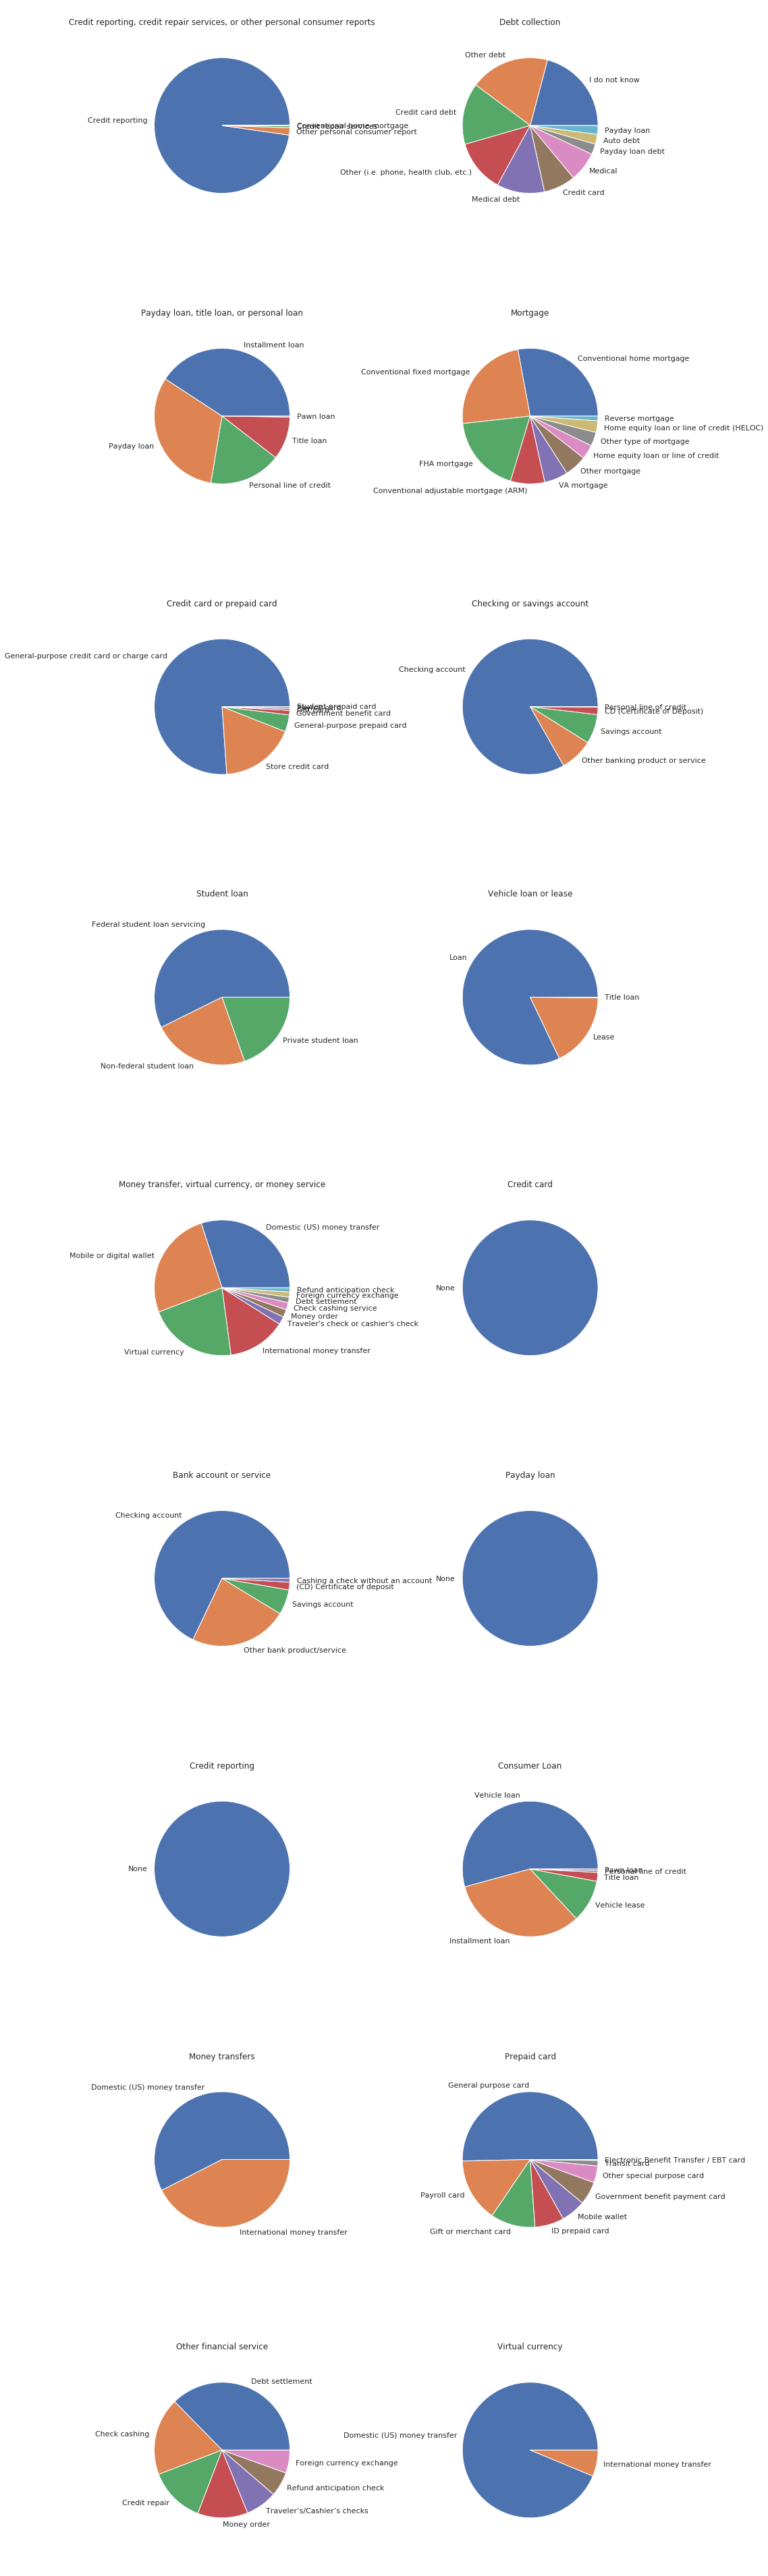

In [7]:
products = complaints["Product"].unique()
names = [x for x in products]

fig = plt.figure(figsize = (15,70))
#plt.rcParams.update({'font.size': 22})
#fig.subplots_adjust(hspace=0.1, wspace=0.3)
i = 0
for n in names:
    i = i + 1
    subplt = fig.add_subplot(9,2,i)
    subplt.set_title(n, y=0.9)
    x = complaints[complaints["Product"] == n]
    counts = x["Sub-product"].value_counts()[:10]
    plt.pie(counts.values, labels = counts.index, radius=0.7)
plt.show()

There are many products where one sub-product dominates the distributions. There's also products with few/no subproduct categories. 


Let's now look at issues and sub-issues. The distributions of the sub-issues for each issue are the following:

In [8]:
temp = complaints['Issue'].value_counts();

# to limit output: 
# for i in range 10:
# else 
for i in range(len(temp)):
    print(f'\n{temp.index[i]}: {temp[i]}')
    temp2 = (complaints[complaints['Issue'] == temp.index[i]]['Sub-issue'].value_counts())
    for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Incorrect information on your report: 77776
		Information belongs to someone else: 32324
		Account status incorrect: 15559
		Account information incorrect: 15060
		Old information reappears or never goes away: 4282
		Personal information incorrect: 4058
		Public record information inaccurate: 3900
		Information is missing that should be on the report: 1726
		None: 512
		Information is incorrect: 298
		Information that should be on the report is missing: 57

Problem with a credit reporting company's investigation into an existing problem: 38424
		Their investigation did not fix an error on your report: 27394
		Investigation took more than 30 days: 3027
		Difficulty submitting a dispute or getting information about a dispute over the phone: 2877
		Was not notified of investigation status or results: 2616
		Problem with personal statement of dispute: 2317
		None: 193

Attempts to collect debt not owed: 28629
		Debt is not yours: 14708
		Debt was paid: 6413
		Debt was result of identity t

Clearly there are way more issues than products, for some issues there are many subissues, while for some there's no subissue at all (similar as with products and sub-products)


Let's visualize the issues by product:

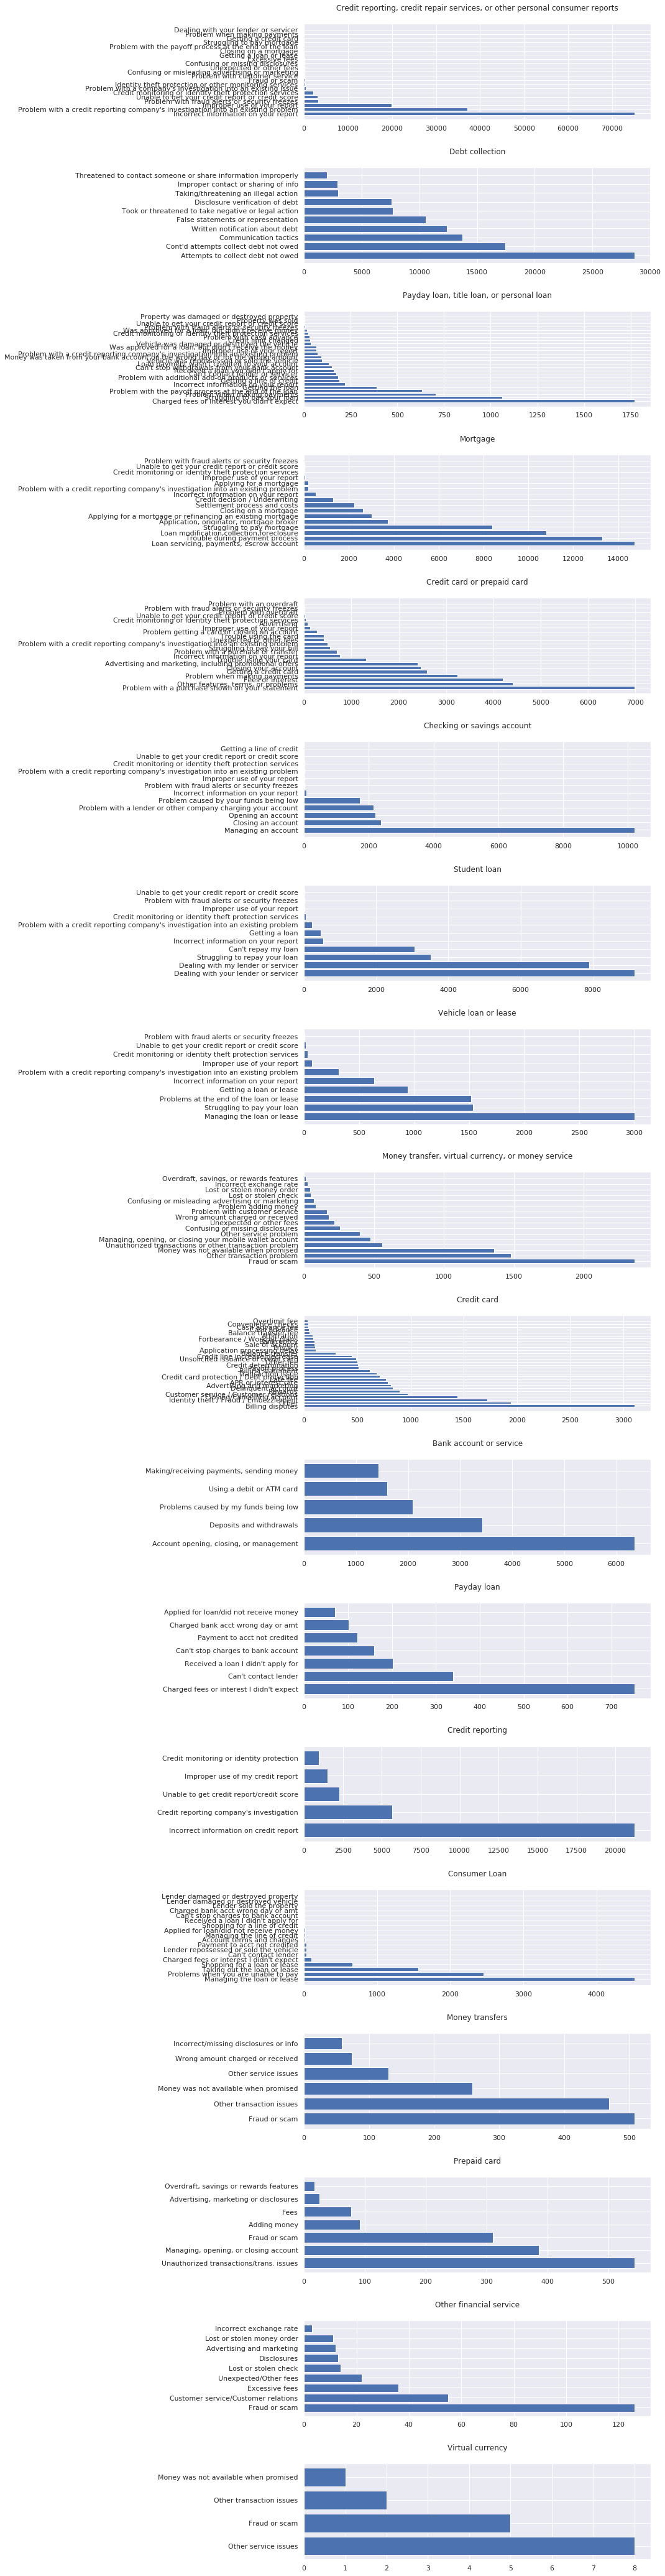

In [9]:
products = complaints["Product"].unique()
names = [x for x in products]

fig = plt.figure(figsize = (10,75))
#plt.rcParams.update({'font.size': 26})
fig.subplots_adjust(hspace=0.5)
i = 0
for n in names:
    i = i + 1
    ax = fig.add_subplot(18,1,i)
    ax.set_title(n, y=1.1)
    x = complaints[complaints["Product"] == n]
    counts = x["Issue"].value_counts()

    y_pos = np.arange(len(counts))
    ax.barh(y_pos, counts.values, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(counts.index)
    
plt.show()

Some issues appear in several products. Below the issues are printed along with each product category it appears in

In [10]:
temp = complaints['Issue'].value_counts();

for i in range(len(temp)):
    
    temp2 = (complaints[complaints['Issue'] == temp.index[i]]['Product'].value_counts())
    if len(temp2) > 1:
        print(f'\n{temp.index[i]}: {temp[i]}')
        for j in range(len(temp2)):
            print(f'\t\t{temp2.index[j]}: {temp2[j]}')


Incorrect information on your report: 77776
		Credit reporting, credit repair services, or other personal consumer reports: 75050
		Credit card or prepaid card: 761
		Vehicle loan or lease: 639
		Student loan: 531
		Mortgage: 511
		Payday loan, title loan, or personal loan: 219
		Checking or savings account: 65

Problem with a credit reporting company's investigation into an existing problem: 38424
		Credit reporting, credit repair services, or other personal consumer reports: 37107
		Credit card or prepaid card: 496
		Vehicle loan or lease: 317
		Student loan: 223
		Mortgage: 193
		Payday loan, title loan, or personal loan: 72
		Checking or savings account: 16

Improper use of your report: 20239
		Credit reporting, credit repair services, or other personal consumer reports: 19878
		Credit card or prepaid card: 132
		Vehicle loan or lease: 74
		Payday loan, title loan, or personal loan: 67
		Mortgage: 50
		Student loan: 21
		Checking or savings account: 17

Dealing with your lender or

## 1.2. Problems

* Sub-product and Sub-issue are not always present
* Product columns/topics are overlapping, we could change to:        
    * Mortgage (cat A)
    * Loan (cat B)
        * Consumer Loan
        * Payday loan
        * Payday loan, title loan, or personal loan
        * Student loan
        * Vehicle loan or lease
    * Card (cat C)
        * Credit card
        * Credit card or prepaid card
        * Prepaid card
    * Credit (cat D)
        * Credit reporting
        * Credit reporting, credit repair services, or other personal consumer reports
    * Other financial service (cat E)
        * Money transfer, virtual currency, or money service
        * Money transfers
        * Virtual currency
        * Bank account or service
        * Checking or savings account
    * Debt collection (cat F)
* Similarly there's an overlap between issues
* Some Products have the same issue names
* The dataset is very unbalanced so preprocessing is definitely required

# 2. Preparation of the data

In order to address the problems, we addressed we prepared our data. For instance, we created our own product categories. We did this because we found the original Product categories to overlap. We generalized these products because we felt that, for example, all loan related complaints should be handled in a similar manner.

## 2.1. Simplification and Balancing

The following code uses a dictionary to map the original Product columns to the new ones. Using this object one could easily expand/modify the mapping when the data changes overtime. 

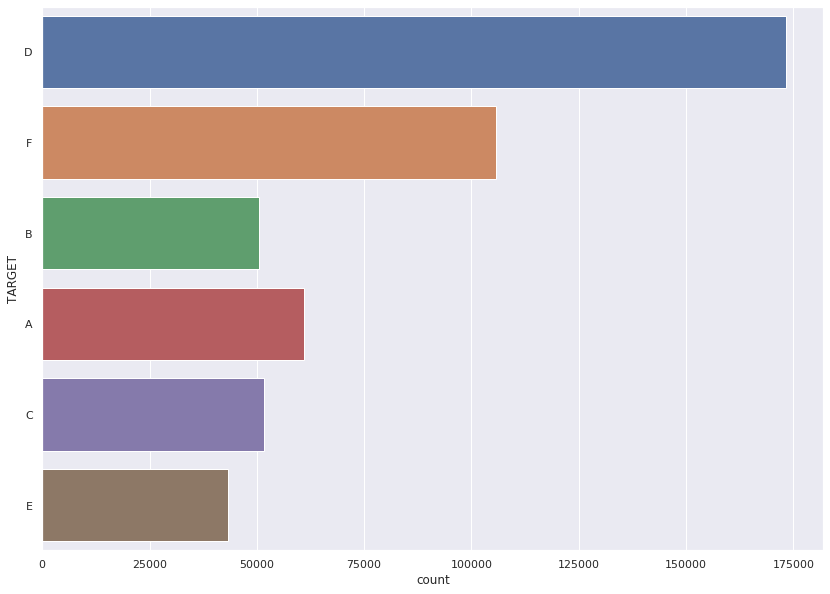

In [11]:
# simplifying dataset
simp_map = {
    'Debt collection' : 'F', 
    'Payday loan' : 'B', 
    'Mortgage' : 'A', 
    'Bank account or service' : 'E', 
    'Consumer Loan' : 'B', 
    'Other financial service' : 'E', 
    'Vehicle loan or lease' : 'B',
    'Payday loan, title loan, or personal loan' : 'B', 
    'Money transfers' : 'E', 
    'Student loan' : 'B', 
    'Virtual currency': 'E', 
    'Credit reporting, credit repair services, or other personal consumer reports' : 'D', 
    'Credit card' : 'C', 
    'Checking or savings account' : 'E', 
    'Prepaid card' : 'C', 
    'Money transfer, virtual currency, or money service' : 'E', 
    'Credit reporting': 'D', 
    'Credit card or prepaid card' : 'C'}

featureSet = complaints[['Product', 'Consumer complaint narrative']].copy()
featureSet['TARGET'] = featureSet['Product'].map(simp_map)

plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=featureSet)
plt.show()

We can see that the dataset is imbalanced, this could cause the model to collapse to the trivial solution of always returning the same prediction. We will resolve this by subsampling in order to flatten the distribution. First let's replace every category by a subsample of that category, limited to 50.000 elements.


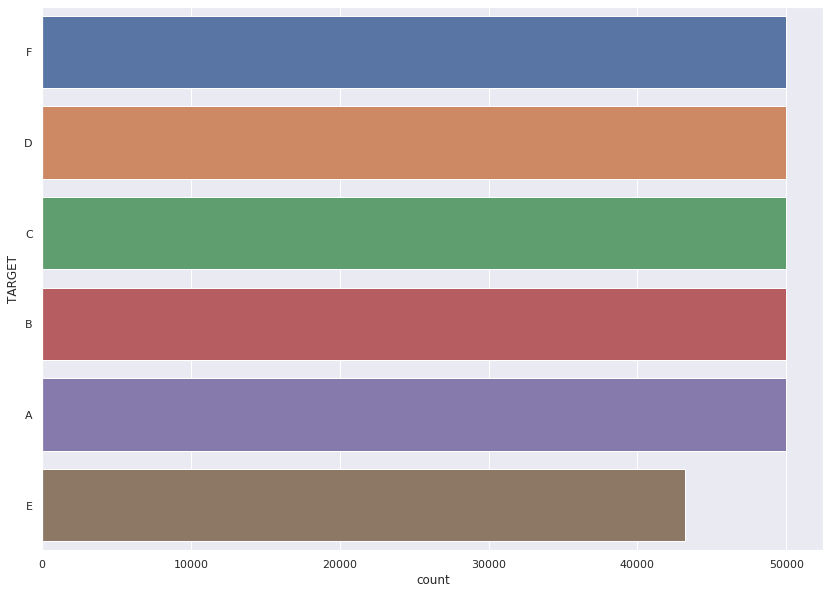

In [12]:
for c in ['A', 'B', 'C', 'D', 'E', 'F']:
    if featureSet[featureSet['TARGET'] == c].shape[0] > 50000:
        featureSet = pd.concat(objs=[featureSet[featureSet['TARGET'] == c].sample(n=50000), featureSet[featureSet['TARGET'] != c]])

plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=featureSet)
plt.show()

Let's now take a sample from this set that shall be used during the project. The size of the subsample is very important. Too little and your model might be overtuned to some texts, while being undertuned to others. 

The bigger the subsample the more accurate your model will be for the whole dataset. However, in order to not overburden our CPU's, we limit it during the project to 10000. 

A fixed seed is also added so that the same sample is produced every time. We do this in order to keep consistency when running hte notebook several times over and over but it's not stictly needed. Needless to say this can lead to exploits where the model performs very well for this one sample. This is not our intention, the only reason the seed given below is used is because it gives an equalish amount of rows for every target. 

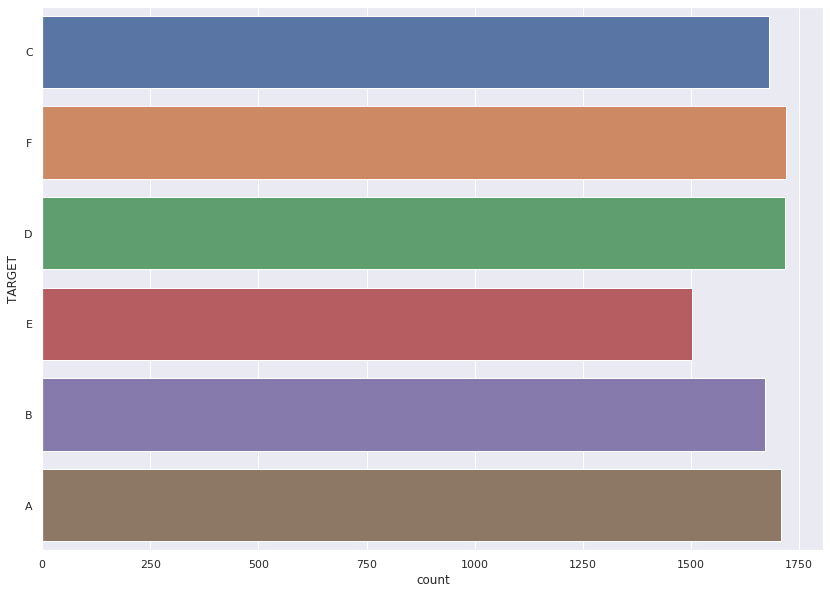

In [13]:
data = featureSet.sample(10000,random_state=7844569)
plt.figure(figsize=(14,10))
sns.set()
sns.countplot(y='TARGET', data=data)
plt.show()

## 2.2. Feature extraction and behind the scenes preprocessing

In order for the computer to understand the customers complaints we needed to use Natural Language Processing techniques. We need to extract features from the messages. 

We chose TF-IDF for its normalization features instead of using a simple bag of words. We remembered: "A word that occurs often in a certain document but does not occur often in other documents is probably an important word for this document." This seemed very useful in our case since mails generally follow a fixed pattern and use rather similar vocabulary.

In [14]:
%%time

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(data['Consumer complaint narrative'])
print(X_train_counts.shape)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
print(X_train_tfidf.shape)

(10000, 20774)
(10000, 20774)
CPU times: user 1.78 s, sys: 65.8 ms, total: 1.84 s
Wall time: 1.97 s


## 2.3. Dimensionality Reduction

The TF-IDF vector is sparse, when converting to a normal vector with the `.todense()`function memory overflowed. 
We tried this at first in order to use basic Primary Component Analysis. The SparsePCA would have been a possible solution. However, while researching this problem we encountered a better solution since we used TF-IDF: TruncatedSVD. TruncatedSVD:
[source](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html)
>In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).
We had to find a way around this. 

Hyperparameter 100 was chosen because this is what the document recommends for LSA.

In [15]:
%%time
svd = TruncatedSVD(n_components=100)
tfidf_reduced = svd.fit_transform(X_train_tfidf)
print(tfidf_reduced.shape)
print(type(tfidf_reduced))

(10000, 100)
<class 'numpy.ndarray'>
CPU times: user 3.76 s, sys: 414 ms, total: 4.17 s
Wall time: 5.06 s


## 2.4. Train Test Split

In order to make sure we have data left that the model has never seen before, we split the data. 

This is an important step because when testing the model we want to make sure we use data that the model sees for the first time.

In [16]:
%%time
y = data['TARGET']
x = tfidf_reduced
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size = 0.2)
#print(x_train.shape)

CPU times: user 9.62 ms, sys: 2.8 ms, total: 12.4 ms
Wall time: 30.3 ms


# 3. Supervised machine learning

Let's now use the preprocessed data with some machine learning algorithms.

## 3.1. K-nearest neighbors

This is the first classifier we decided to try. Knn doesn't actually 'train' on the data (there's no processing time required). All it does is store the given data points. When making a prediction, the algorithm checks which given datapoints were closest according to a distance function. It then returns the best suitable class.

In [17]:
%%time
#%%script false --no-raise-error

knn = KNeighborsClassifier(algorithm='kd_tree')
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)
(predictions == y_test).mean()

CPU times: user 4.38 s, sys: 46.3 ms, total: 4.43 s
Wall time: 5.16 s


0.684

By selecting different samples and using different train and test sets, we get an accuracy of about 65% with standard Knn.

### 3.1.1. Hyper Parameter Tuning (K)

The amount of nearest neighbours can be tuned in order to pinpoint a good value. We did this by plotting the accuracy for different values.

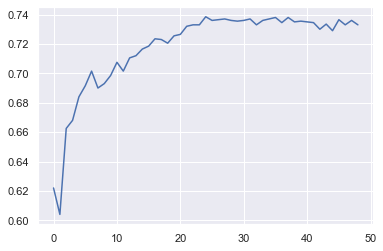

CPU times: user 3min 30s, sys: 1.75 s, total: 3min 32s
Wall time: 3min 51s


In [18]:
%%time
#%%script false --no-raise-error

accuracies = []
for k in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=k, algorithm='kd_tree')
    knn.fit(x_train, y_train)
    predictions = knn.predict(x_test)
    accuracies.append((predictions == y_test).mean())
plt.plot(accuracies)
plt.show()

For this sample, the graph showed us that 15 would be a more appropriate value for k instead of the default of 5. 

The score for this model is: 0.7165
CPU times: user 8.38 s, sys: 84.7 ms, total: 8.47 s
Wall time: 8.99 s


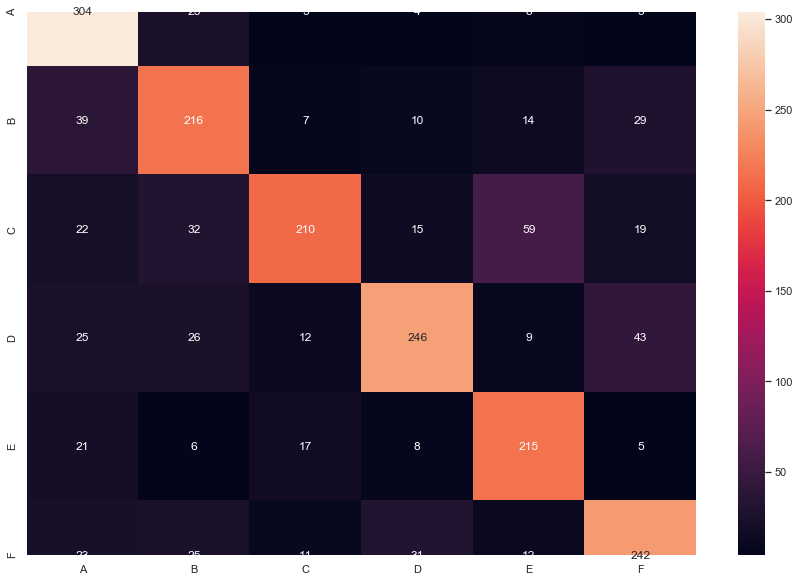

In [19]:
%%time
#%%script false --no-raise-error

knn = KNeighborsClassifier(n_neighbors=15, algorithm='kd_tree')
knn.fit(x_train, y_train)
predictions = knn.predict(x_test)
cm = confusion_matrix(y_test, predictions)

print(f'The score for this model is: {knn.score(x_test, y_test)}')
labels = ['A', 'B', 'C', 'D', 'E', 'F']

fig = plt.figure(figsize = (15,10))
sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels, yticklabels=labels)

Another hyperparameter of Knn is the distance algorithm used, we didn't check this out.

We could delve deeper into the hyperparameters and use GridSearchCV. This calculates the correct hyperparameters for you by doing an exhausive grid search. It is also useful for cross-validation, which we didn't check here. With cross-validation, different overlapping training and test sets are derived from the same dataset in order to make sure the same hyperparameters perform well. GridSearchCV will be used later on so we don't have to do this work manually. 

This model has about 70% accuracy. Not bad considering a random classifier with 6 classes has 16,6% accuracy (the perfect one 100%). However we decided we wanted to check if logistic regression does a better job at this task.


## 3.2 Logistic Regression

Since we know that logistic regression is much faster on large datasets, we decided to try a LR classifier as well.

In [20]:
%%time
#%%script false --no-raise-error
lr = LogisticRegression(random_state=0, multi_class='auto', max_iter=1000)
lr.fit(x_train, y_train)

print(lr.score(x_test, y_test))

/Users/Tim/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.809
CPU times: user 989 ms, sys: 18.6 ms, total: 1.01 s
Wall time: 1.03 s


This model has about 80% accuracy. We improved our model by 10% by simply using a different classifier algorithm. But in order to achieve better results we decided to tune de hyperparameters even further.

### 3.2.1 (better) hyperparameter tuning

Let's now use GridSearchCV in order to find good hyperparameters. We will also validate the model / tune it even better by using cross-validation. Here 5 folds are used.

The hyperparameters for logistic regression can be found at https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. 

In [21]:
from sklearn.model_selection import GridSearchCV

paramGrid = {'C': [0.1, 1, 10, 100, 1000, 10000],  'solver' : ['newton-cg', 'liblinear']}

search = GridSearchCV(estimator=lr, param_grid=paramGrid, cv=5)
search.fit(x_train,y_train)#? ipv x_train ect
print(search.best_params_)

{'C': 100, 'solver': 'liblinear'}


To no one's surprise the best solver is liblinear as the docs state it performs better but is slower contrary to other solvers.

In [22]:
model = search.best_estimator_
predictions = model.predict(x_test)
(predictions == y_test).mean()

0.815

## 3.3. Support Vector Machines

Since we know logistic regression and support vector machines both perform well with a large amount of features we tried a SVM classifier for good measure. 

### 3.3.1 Linear

In [23]:
%%time
#%%script false --no-raise-error
lin_svm = svm.LinearSVC()
lin_svm.fit(x_train, y_train)
print(lin_svm.score(x_test, y_test))

0.81
CPU times: user 640 ms, sys: 11.4 ms, total: 652 ms
Wall time: 655 ms


### 3.3.2. Non-linear SVM

The generates the same result as the example above, but it takes longer.

In [24]:
%%time
#%%script false --no-raise-error

nlin_svm = svm.NuSVC(gamma='auto')
nlin_svm.fit(x_train, y_train)
print(nlin_svm.score(x_test, y_test))

0.803
CPU times: user 16.8 s, sys: 163 ms, total: 17 s
Wall time: 19.8 s


## 4. Doc2Vec
- text preprocessing:
    - lower case
    - remove punctuation
    - remove unnecessary whitespace
    - remove stopwords
    - remove html
    
https://medium.com/wisio/a-gentle-introduction-to-doc2vec-db3e8c0cce5e
- doc2vec introduction
   
https://www.geeksforgeeks.org/text-preprocessing-in-python-set-1/
- removing punctuation, lower case without libraries

https://stackoverflow.com/questions/9662346/python-code-to-remove-html-tags-from-a-string
- using beautifulsoup to remove html

https://stackoverflow.com/questions/11460855/how-to-remove-duplicates-only-if-consecutive-in-a-string
- remove consecutive xxxx's 

https://www.geeksforgeeks.org/tokenize-text-using-nltk-python/
- tokenize with nltk

https://pythonspot.com/nltk-stop-words/
- nltk stop words

https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
- doc2vec model

https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4
- general

Doc2Vec is an algorithm that enables numeric representation of text documents. It is based on word2vec. Doc2vec uses the continuous bag of words just like word2vec but adds a document vector for each document.
Sklearn does not have a word2vec or doc2vec implementation. Gensim is used.

In [ ]:
from bs4 import BeautifulSoup
import string
import re
import sys 
!conda install --yes --prefix {sys.prefix} nltk bs4 gensim
import nltk
nltk.download('punkt')
nltk.download('stopwords')

### Preprocessing:
    - lower case words
    - remove html
    - remove xxxx's

In [15]:
def preprocessing(text):
    text = BeautifulSoup(text, "html.parser").text
    text = text.lower()
    translator = str.maketrans('', '', string.punctuation) 
    text = text.translate(translator)
    text = re.sub(r'(x)\1+', '', text)
    return text

data['Consumer complaint narrative'] = data['Consumer complaint narrative'].apply(preprocessing)

### Tokenize the data using nltk. Remove stopwords using nltk.
Countvectorizer has removal of stopwords builtin. It is not builtin with the gensim doc2vec model.

In [16]:
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords
stopWords = stopWords = set(stopwords.words('english'))

def tokenize(text):
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if word not in stopWords:
                tokens.append(word)
    return tokens

In [17]:
train, test = train_test_split(data, test_size = 0.2)

### split the data and create TaggedDocuments using gensim

In [18]:
from gensim.models.doc2vec import TaggedDocument

train_corpus = train.apply(lambda row: TaggedDocument(words=tokenize(row['Consumer complaint narrative']), tags=[row["TARGET"]]), axis=1)
test_corpus = test.apply(lambda row: TaggedDocument(words=tokenize(row['Consumer complaint narrative']), tags=[row["TARGET"]]), axis=1)
train_corpus

416734    ([tried, go, onto, website, making, sure, init...
443491    ([charged, overdraft, fee, 3500, bank, america...
137775    ([recently, received, collection, notice, fro,...
142174    ([initiated, wire, transfer, 2016, bank, ameri...
140072    ([chase, bank, account, updated, bank, cause, ...
                                ...                        
23912     ([2019, disputed, 2, charges, credit, card, 1,...
138044    ([checking, account, bank, america, closed, du...
327294    ([requested, line, credit, instead, gave, seco...
67682     ([writing, today, dispute, recent, reporting, ...
105546    ([real, property, note, sold, corresponding, s...
Length: 8000, dtype: object

### create a doc2vec model using the gensim library

In [19]:
%%time
import gensim

model = gensim.models.doc2vec.Doc2Vec(vector_size=20, min_count=2, epochs=10, workers=8)
model.build_vocab(train_corpus)
model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 23.1 s, sys: 2.09 s, total: 25.1 s
Wall time: 15.7 s


### create vectors that are usable in the logistic regression functions

In [20]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, epochs=model.epochs)) for doc in sents])
    return targets, regressors

y_train, X_train = vec_for_learning(model, train_corpus)
y_test, X_test = vec_for_learning(model, test_corpus)

In [21]:
%%time
#%%script false --no-raise-error
lr = LogisticRegression(random_state=0, multi_class='auto', max_iter=1000)
lr.fit(X_train, y_train)

print(lr.score(X_test, y_test))

0.7645
CPU times: user 2.46 s, sys: 2.62 s, total: 5.08 s
Wall time: 722 ms
